# Mallard Duck Wing Dynamics

Team 3

In [1]:
#pip install pynamics

In [2]:
%matplotlib inline
import scipy.optimize
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
plt.ion()
from math import pi, sin, cos, tan, asin, acos, atan, degrees, radians, pi

In [3]:
def prettyplot(x,y): # Function plots mechanism and generates labels
    # Create Figure
    Fig1 = plt.figure(figsize=[15,15])
    ax = Fig1.add_axes([0.0, 0.0, 1.0, 1.0], aspect='equal')
    
    # plot links and joints
    plt.plot(x[0:3],y[0:3],color='tab:blue')
    plt.plot(x[2:5],y[2:5],color='tab:green')
    plt.plot(x[4:],y[4:],color='k')
    plt.scatter(x,y,color='k')
    plt.axis('equal')
    plt.xlim([-0.1,0.5])
    
    # label joints
    for i in range(0, len(x)-1):
        plt.text(x[i]-0.004, y[i]-0.004, "p"+str(i), verticalalignment='top', horizontalalignment='right', fontsize=14)
    
    # plot COMs
    comx = [(x[0]+x[1])/2, (x[1]+x[2])/2, (x[4]+x[3])/2, (x[3]+x[2])/2, (x[4]+x[0])/2]
    comy = [(y[0]+y[1])/2, (y[1]+y[2])/2, (y[4]+y[3])/2, (y[3]+y[2])/2, (y[4]+y[0])/2]
    plt.scatter(comx,comy,color='k')
    
    # label COMs
    linknames = ['A', 'B', 'C', 'D', 'E']
    for i in range(0, len(comx)):
        plt.text(comx[i]+0.004, comy[i], linknames[i], verticalalignment='bottom', horizontalalignment='left', weight='bold', fontsize=16)
    
    # label properties
    propertynames = ['La', 'Lb', 'Lc', 'Ld', 'Le']
    for i in range(0, len(comx)):
        plt.text(comx[i]+0.016, comy[i], propertynames[i], verticalalignment='bottom', horizontalalignment='left', fontsize=14)
    
    
    # plot frame axes
    alen = 0.04    
    plt.arrow(0, 0, alen, 0,head_width=0.008,width=0.0004,color='r')
    plt.arrow(0, 0, 0, alen,head_width=0.008,width=0.0004,color='r')
    vx = []
    vy = []
    for i in range(1, len(x)-2):
        if i <= 2: 
            vecx = numpy.array([x[i]-x[i-1], y[i]-y[i-1]])
            vecx = vecx/(vecx.dot(vecx)**0.5)
            vecy = numpy.cross([0,0,1], vecx)[0:2]
            plt.arrow(x[i], y[i], alen*vecx[0], alen*vecx[1],head_width=0.008,width=0.0004,color='b')
            plt.arrow(x[i], y[i], alen*vecy[0], alen*vecy[1],head_width=0.008,width=0.0004,color='b')
            vx.append(vecx)
            vy.append(vecy)
        if i >= 2:
            vecx = numpy.array([x[i]-x[i+1], y[i]-y[i+1]])
            vecx = vecx/(vecx.dot(vecx)**0.5)
            vecy = numpy.cross([0,0,1], vecx)[0:2]
            plt.arrow(x[i], y[i], alen*vecx[0], alen*vecx[1],head_width=0.008,width=0.0004,color='g')
            plt.arrow(x[i], y[i], alen*vecy[0], alen*vecy[1],head_width=0.008,width=0.0004,color='g')
            vx.append(vecx)
            vy.append(vecy)

    # label frames
    lablen = 0.06

    plt.text(x[0]+0.06, y[0], 'Nx', verticalalignment='center', horizontalalignment='center', color='r', fontsize=14)
    plt.text(x[0], y[0]+0.06, 'Ny', verticalalignment='center', horizontalalignment='center', color='r', fontsize=14)
    
    plt.text(x[1]+lablen*vx[0][0], y[1]+lablen*vx[0][1], 'Ax', verticalalignment='center', horizontalalignment='center', color='b', fontsize=14)
    plt.text(x[1]+lablen*vy[0][0], y[1]+lablen*vy[0][1], 'Ay', verticalalignment='center', horizontalalignment='center', color='b', fontsize=14)

    plt.text(x[2]+lablen*vx[1][0], y[2]+lablen*vx[1][1], 'Bx', verticalalignment='center', horizontalalignment='center', color='b', fontsize=14)
    plt.text(x[2]+lablen*vy[1][0], y[2]+lablen*vy[1][1], 'By', verticalalignment='center', horizontalalignment='center', color='b', fontsize=14)

    plt.text(x[3]+lablen*vx[3][0], y[3]+lablen*vx[3][1], 'Cx', verticalalignment='center', horizontalalignment='center', color='g', fontsize=14)
    plt.text(x[3]+lablen*vy[3][0], y[3]+lablen*vy[3][1], 'Cy', verticalalignment='center', horizontalalignment='center', color='g', fontsize=14)

    plt.text(x[2]+lablen*vx[2][0], y[2]+lablen*vx[2][1], 'Dx', verticalalignment='center', horizontalalignment='center', color='g', fontsize=14)
    plt.text(x[2]+lablen*vy[2][0], y[2]+lablen*vy[2][1], 'Dy', verticalalignment='center', horizontalalignment='center', color='g', fontsize=14)

    # plot angles
    Aang1 = 0
    Aang2 = degrees(atan(vx[0][1]/vx[0][0]))
    ax.add_patch(Arc((0, 0), 0.04, 0.04, theta1=min(Aang1, Aang2), theta2=max(Aang1, Aang2), edgecolor='k', linewidth=0.0006, label='q1'))

    Bang1 = degrees(atan(vx[0][1]/vx[0][0]))
    Bang2 = degrees(atan(vx[1][1]/vx[1][0]))
    ax.add_patch(Arc((x[1], y[1]), 0.04, 0.04, theta1=min(Bang1, Bang2), theta2=max(Bang1, Bang2), edgecolor='k', linewidth=0.0006))

    plt.plot([0,0.04],[0.04,0.04],color='k',linewidth=1)
    Cang1 = 0
    Cang2 = degrees(atan(vx[3][1]/vx[3][0]))
    ax.add_patch(Arc((x[4], y[4]), 0.04, 0.04, theta1=min(Cang1, Cang2), theta2=max(Cang1, Cang2), edgecolor='k', linewidth=0.0006))

    Dang1 = degrees(atan(vx[3][1]/vx[3][0]))
    Dang2 = degrees(atan(vx[2][1]/vx[2][0]))
    ax.add_patch(Arc((x[3], y[3]), 0.04, 0.04, theta1=min(Dang1, Dang2), theta2=max(Dang1, Dang2), edgecolor='k', linewidth=0.0006))

    # label angles
    plt.text(x[0]+0.032*cos(radians((Aang1+Aang2)/2)), y[0]+0.032*sin(radians((Aang1+Aang2)/2)), 'qA', verticalalignment='center', horizontalalignment='center', fontsize=14)
    plt.text(x[1]+0.032*cos(radians((Bang1+Bang2)/2)), y[1]+0.032*sin(radians((Bang1+Bang2)/2)), 'qB', verticalalignment='center', horizontalalignment='center', fontsize=14)
    plt.text(x[4]+0.032*cos(radians((Cang1+Cang2)/2)), y[4]+0.032*sin(radians((Cang1+Cang2)/2)), 'qC', verticalalignment='center', horizontalalignment='center', fontsize=14)
    plt.text(x[3]+0.032*cos(radians((Dang1+Dang2)/2)), y[3]+0.032*sin(radians((Dang1+Dang2)/2)), 'qD', verticalalignment='center', horizontalalignment='center', fontsize=14)

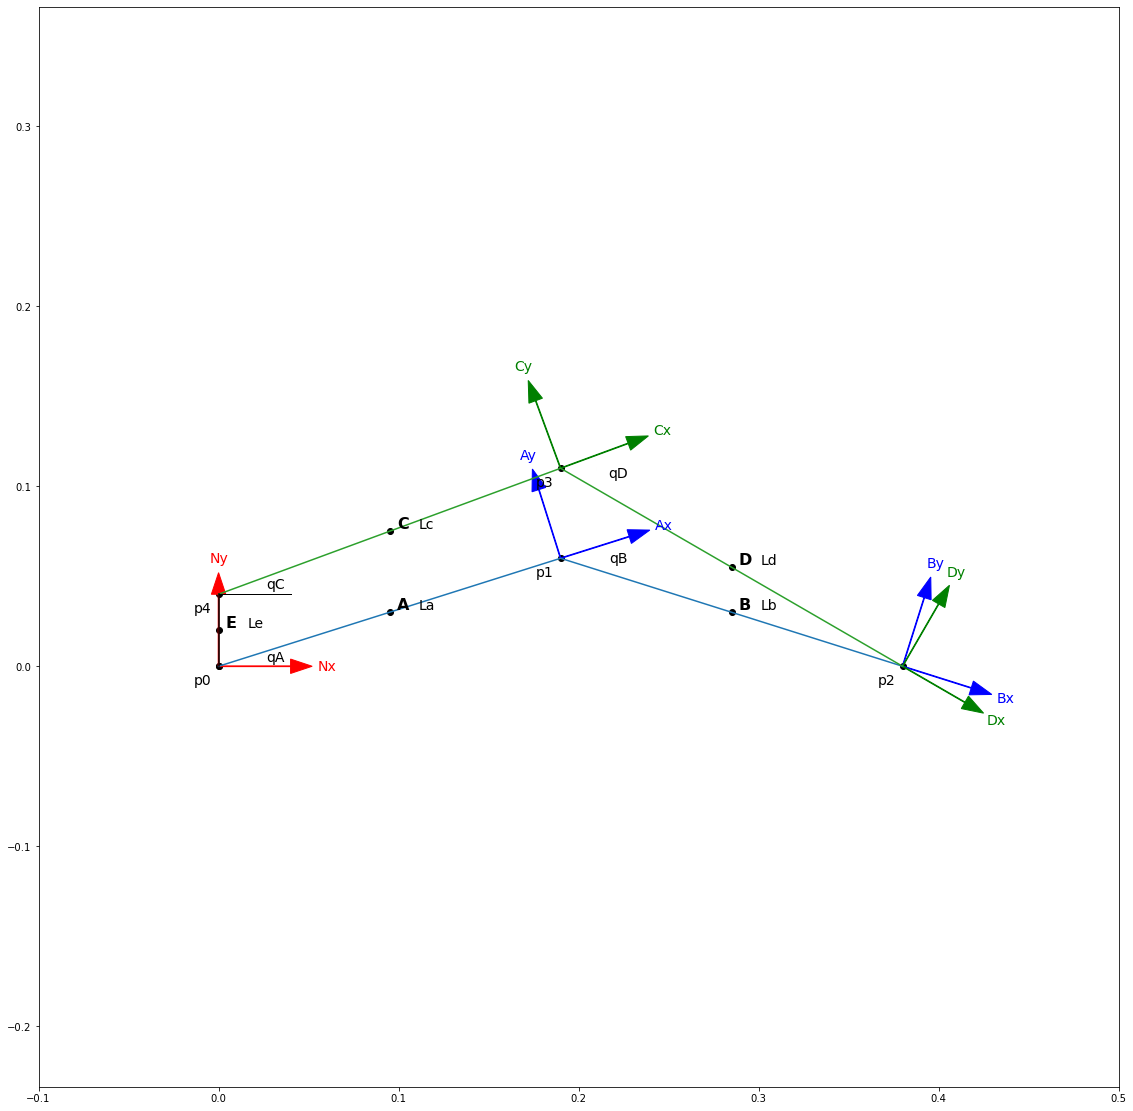

In [4]:
# Kinematics Demo Position
x = numpy.array([0, 0.19, 0.38, 0.19, 0, 0])
y = numpy.array([0, 0.06, 0, 0.11, 0.04, 0])
prettyplot(x,y)

In [5]:
# Create a pynamics system
system = System()
pynamics.set_system(__name__,system)

In [6]:
# Declare constants
lA_num = 0.2
lB_num = 0.2
lC_num = 0.22
lD_num = 0.2
lE_num = 0.04

lA = Constant(lA_num,'lA',system)
lB = Constant(lB_num,'lB',system)
lC = Constant(lC_num,'lC',system)
lD = Constant(lD_num,'lD',system)
lE = Constant(lE_num,'lE',system)

In [7]:
### New

1. Scale: Ensure your system is using SI units. You should be specifying lengths in meters (so millimeters should be scaled down to the .001 range), forces in Newtons, and radians (not degrees), and masses in kg. You may make educated guesses about mass for now.

All units are in SI

In [8]:
# Dynamics Parameters
mA = Constant(1,'mA',system)
mB = Constant(1,'mB',system)
mC = Constant(1,'mC',system)
mD = Constant(1,'mD',system)
mE = Constant(1,'mE',system)

preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)
preload4 = Constant(0*pi/180,'preload4',system)

Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)
Ixx_D = Constant(1,'Ixx_D',system)
Iyy_D = Constant(1,'Iyy_D',system)
Izz_D = Constant(1,'Izz_D',system)
Ixx_E = Constant(1,'Ixx_E',system)
Iyy_E = Constant(1,'Iyy_E',system)
Izz_E = Constant(1,'Izz_E',system)

6. Tuning: Now adjust the damper value  to something nonzero, that over 10s shows that the system is settling.

In [9]:
g = Constant(9.81,'g',system)
b = Constant(1e1,'b',system)
k = Constant(1e1,'k',system)

In [10]:
# Integration Tolerance
tol = 1e-12

In [11]:
# Time
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [12]:
###

In [13]:
# Create differentiable state variables
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)

In [14]:
# initial values
# qC = 11.97 creates fully extended, horizontal wing
initialvalues = {}
initialvalues[qA]=0*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=0*pi/180
initialvalues[qB_d]=0*pi/180

initialvalues[qC]=11.97*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qD]=0*pi/180
initialvalues[qD_d]=0*pi/180

In [15]:
# Retrieve state variables in the order they are stored in the system
# Create a list of initial values ini0 in the order of the system’s state variables
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

In [16]:
# Create frames
N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')
D = Frame('D')

In [17]:
# Declare N as the Newtonian (fixed) frame
system.set_newtonian(N)

In [18]:
# Rotate other frames about their local Z axes.
# Not global q
A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
B.rotate_fixed_axis_directed(A,[0,0,1],qB,system)
C.rotate_fixed_axis_directed(N,[0,0,1],qC,system)
D.rotate_fixed_axis_directed(C,[0,0,1],qD,system)

In [19]:
# Define rigid body kinematics
# position vectors
p0 = 0*N.x #Normal
p1 = p0 + lA*A.x #Link A
p2A = p1 + lB*B.x #Link B - OUTPUT
p4 = p0 + lE*N.y #Link E
p3 = p4 + lC*C.x #Link C
p2C = p3 + lD*D.x #Link D - OUTPUT

In [20]:
### NEW

2. Define Inertias: Add a center of mass and a particle or rigid body to each rotational frame. You may use particles for now if you are not sure of the inertial properties of your bodies, but you should plan on finding these values soon for any “payloads” or parts of your system that carry extra loads (other than the weight of paper).

In [21]:
# CoM vectors
pAcom=p0 + lA/2*A.x #Link A
pBcom=p1 + lB/2*B.x #Link B
pCcom=p4 + lC/2*C.x #Link C
pDcom=p3 + lD/2*D.x #Link D
pEcom=p0 + lE/2*N.y #Link E

In [22]:
# Angular Velocity
wNA = N.getw_(A)
wAB = A.getw_(B)
wNC = N.getw_(C)
wCD = C.getw_(D)

In [23]:
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)
IE = Dyadic.build(E,Ixx_E,Iyy_E,Izz_E)

BodyA = Body('BodyA',A,pAcom,mA,IA,system)
BodyB = Body('BodyB',B,pBcom,mB,IB,system)
BodyC = Body('BodyC',C,pCcom,mC,IC,system)
BodyD = Body('BodyD',D,pDcom,mD,ID,system)
BodyE = Body('BodyE',E,pCcom,mE,IE,system)
#BodyC = Particle(pCcm,mC,'ParticleC',system)

NameError: name 'E' is not defined

3. Add Forces: Add the acceleration due to gravity. Add rotational springs in the joints (using k=0 is ok for now) and a damper to at least one rotational joint. You do not need to add external motor/spring forces but you should start planning to collect that data.

In [ ]:
# Forces
system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wNC,wNC)
system.addforce(-b*wCD,wCD)

7. (Optional): Adjust joint stiffness values so that your system looks more realistic.

In [ ]:
# Spring Forces
# Not global q
system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
system.add_spring_force1(k,(qB-preload2)*A.z,wAB)
system.add_spring_force1(k,(qC-preload3)*N.z,wNC)
system.add_spring_force1(k,(qD-preload4)*C.z,wCD)

In [ ]:
# Gravity
system.addforcegravity(-g*N.y)

5. Solution: Add the code from the bottom of the pendulum example for solving for f=ma, integrating, plotting, and animating. Run the code to see your results. It should look similar to the pendulum example with constraints added, as in like a rag-doll or floppy

In [ ]:
# F=ma
f,ma = system.getdynamics()

In [ ]:
# Acceleration
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

In [ ]:
# Integrate
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

In [ ]:
# Outputs
plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC','qD'])

In [ ]:
# Energy
KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states)
energy_output.plot_time()

In [ ]:
# Motion
points = [p0,p1,p2A,p3,p4]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
points_output.plot_time(20)

In [ ]:
# Motion Animation
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

In [ ]:
###

4. Constraints: Keep mechanism constraints in, but follow the pendulum example of double-differentiating all constraint equations.
If you defined your mechanism as unattached to the Newtonian frame, add enough constraints so that it is fully attached to ground (for now). you will be eventually removing these constraints.

In [ ]:
# Declare a list of points that will be used for plotting
points = [p0, p1, p2A, p3, p4]

In [ ]:
# Constraints
eq_vector = p2A-p2C
eq = []
eq.append((eq_vector).dot(N.x))
eq.append((eq_vector).dot(N.y))
eq_d=[(system.derivative(item)) for item in eq]

In [ ]:
# Turn constraint equations into a vector
eq_d_sym = sympy.Matrix(eq_d)

In [ ]:
# Turn qi and qd into sympy vectors
qi_sym = sympy.Matrix([qA_d, qC_d])
qd_sym = sympy.Matrix([qB_d, qD_d])

In [ ]:
# Take partial derivative of constraints with respect to independent and dependent variables
AA = eq_d_sym.jacobian(qi_sym)
BB = eq_d_sym.jacobian(qd_sym)

In [ ]:
# Solve for internal input/output Jacobian
Jin = -BB.inv()*AA
Jin.simplify()
Jin

In [ ]:
# Solving for the dependent variables 
qd2_sym = Jin*qi_sym
qd2_sym

In [ ]:
# Substitution dictionary to replace all occurrances of qB_d and qD_d
subs_sym = dict([(ii,jj) for ii,jj in zip(qd_sym,qd2_sym)])
subs_sym

In [ ]:
# End effector position
pend = p2A
pend

In [ ]:
# End effector velocity
vend = pend.time_derivative()
vend = vend.subs(subs_sym)
vend

In [ ]:
# Turn end effector velocity equations into a vector
vend_sym = sympy.Matrix([vend.dot(N.x), vend.dot(N.y)])

In [ ]:
# JACOBIAN
# Take partial derivative of end effector velocities with respect to independent variables
J = vend_sym.jacobian(qi_sym)
J.simplify()
J

In [ ]:
# Identify independent and dependent variables
qi = [qA, qC]
qd = [qB, qD]

In [ ]:
# Create a copy of symbolic constants dictionary and add the initial value of qi to it
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

In [ ]:
# Substitute constants in equation
eq = [item.subs(constants) for item in eq]

In [ ]:
# Convert to numpy array
# Sum the error
error = (numpy.array(eq)**2).sum()

In [ ]:
# Convert to a function that scipy can use.
# Sympy has a “labmdify” function that evaluates an expression, but scipy needs a slightly different format.
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [ ]:
# Take the derivative of the equations to linearize with regard to the velocity variables
guess = [initialvalues[item] for item in qd]
result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]))
#points.plot_time()

In [ ]:
# Valid initial condition
x = numpy.array([points.y[1][0][0], points.y[1][1][0], points.y[1][2][0], points.y[1][3][0], points.y[1][4][0],0])
y = numpy.array([points.y[1][0][1], points.y[1][1][1], points.y[1][2][1], points.y[1][3][1], points.y[1][4][1],0])
prettyplot(x,y)

In [ ]:
# End effector force
Fend_num = numpy.array([0, -2*0.5*9.81]).reshape([2,1])
Fend_num

In [ ]:
# End effector velocity
vend_num = numpy.array([0, -2*45*pi/180*0.4*2]).reshape([2,1])
vend_num

In [ ]:
# Input force symbolic
Fin = sympy.Matrix(J.transpose()*Fend_num)
Fin

In [ ]:
# Input force numeric
Fin_num = Fin.subs([(qA, ini[0]),(qB, ini[1]),(qC, ini[2]),(qD, ini[3]),(lA, lA_num),(lB, lB_num),(lC, lC_num),(lD, lD_num)])
Fin_num

In [ ]:
# Input velocity symbolic
vin = sympy.Matrix(J.inv()*vend_num)
vin

In [ ]:
# Input velocity numeric
vin_num = vin.subs([(qA, ini[0]),(qB, ini[1]),(qC, ini[2]),(qD, ini[3]),(lA, lA_num),(lB, lB_num),(lC, lC_num),(lD, lD_num)])
vin_num

In [ ]:
# Input power symbolic
Pin = sympy.Matrix([[Fin[0]*vin[0]],[Fin[1]*vin[1]]])
Pin

In [ ]:
# Input power numeric
Pin_num = Pin.subs([(qA, ini[0]),(qB, ini[1]),(qC, ini[2]),(qD, ini[3]),(lA, lA_num),(lB, lB_num),(lC, lC_num),(lD, lD_num)])
Pin_num

# References

[1] “Mallard Identification, All About Birds, Cornell Lab of Ornithology,” , All About Birds, Cornell Lab of Ornithology. [Online]. Available: https://www.allaboutbirds.org/guide/Mallard/id. [Accessed: 20-Feb-2021].

[2] W. W. Cochran, M. S. Bowlin, and M. Wikelski, “Wingbeat frequency and flap-pause ratio during natural migratory flight in thrushes,” OUP Academic, 02-Jun-2008. [Online]. Available: https://academic.oup.com/icb/article/48/1/134/627446. [Accessed: 20-Feb-2021]. 

[3] KATHLEEN  D. EARLS, “KINEMATICS AND MECHANICS OF GROUND TAKE-OFF IN THE STARLING STURNIS VULGARIS AND THE QUAIL COTURNIX COTURNIX,” Dec. 1999.

[4] “BEGINNERS FPV DRONE GUIDE,” Custom Quads. [Online]. Available: https://customquads.com.au/pages/fpv-beginners-start-here#:~:text=To%20build%20a%20standard%20FPV,800%20grams%20with%20a%20battery. [Accessed: 20-Feb-2021].
